In [22]:
import os
from itertools import product

import cv2
from pytorch_lightning import Trainer, seed_everything

import matplotlib.pyplot as plt

try:
    import chardet
except:
    % pip install chardet

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import get_callbacks, LoadModelCallback, ImageVisualizerCallback, MetricVisualizerCallback
from anomalib.utils.loggers import get_experiment_logger
from anomalib.post_processing import Visualizer


from anomalib.models.ensemble.ensemble_tiler import EnsembleTiler
from anomalib.models.ensemble.ensemble_functions import (
    TileCollater,
    update_ensemble_input_size_config,
    BasicPredictionJoiner,
    compute_metrics,
)


In [2]:
# Set working directory to anomalib as that is what training script normally assumes
if not os.getcwd().endswith("anomalib"):
    %cd ..
%pwd

C:\Code\GSOC\anomalib


'C:\\Code\\GSOC\\anomalib'

# Add ensembling methods for tiling to Anomalib
## Demo 1

This notebook is part of first demo for OpenVINO GSOC meeting.
It demonstrates the pipeline used for anomaly detection using ensemble of models.

In this pipeline, each image is split into tiles and separate model is then trained on each tile location.

Below, we can find a diagram of the entire pipeline.

![ensemble_small](https://github.com/openvinotoolkit/anomalib/assets/61357777/add34a6e-11fd-4eab-8447-3c45205a2009)


### Configuration

We first load configuration and get all configurable parameters.

In [38]:
CONFIG_PATH = "src/anomalib/models/padim/ens_config_visa.yaml"

config = get_configurable_parameters(config_path=CONFIG_PATH)
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

config = update_ensemble_input_size_config(config)

Global seed set to 42


### Step1: Tiling

The first step of our pipline is tiling of the images. This is done inside dataloader and utilizes EnsembleTiler class that does this image splitting.
Tiler class is responsible for:
- splitting the image into tiles
- untiling the tiles back into single image

In [39]:
tiler = EnsembleTiler(
    tile_size=config.dataset.tiling.tile_size,
    stride=config.dataset.tiling.stride,
    image_size=config.dataset.image_size,
    remove_border_count=config.dataset.tiling.remove_border_count,
)

### Step 2: Training of ensemble & prediction

In next step we train separate model on each tile location. When obtaining the dataloader, we also change its collate function, that takes care of tiling.

By calling `trainer.fit` the model is then trained inside a loop that goes over all tiles.

One the model is trained, we use it to predict anomalies on our test data, again for each tile location.

In [40]:
tile_predictions = {}

# go over all tile positions and train
for tile_index in product(range(tiler.num_patches_h), range(tiler.num_patches_w)):
    print(f"Start of procedure for tile {tile_index}")
    datamodule = get_datamodule(config)

    datamodule.custom_collate_fn = TileCollater(tiler, tile_index)

    model = get_model(config)
    experiment_logger = get_experiment_logger(config)
    callbacks = get_callbacks(config)

    ensemble_callbacks = []
    # temporary removing for ensemble, visualization is done at the end
    for callback in callbacks:
        if not isinstance(callback, (ImageVisualizerCallback, MetricVisualizerCallback)):
            ensemble_callbacks.append(callback)

    trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=ensemble_callbacks)
    print("Training model")
    trainer.fit(model=model, datamodule=datamodule)

    # Load best model weights
    load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
    trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member


    predictions = trainer.predict(model=model, datamodule=datamodule)
    tile_predictions[tile_index] = predictions

C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


Start of procedure for tile (0, 0)


C:\Code\GSOC\anomalib\src\anomalib\utils\callbacks\__init__.py:142: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will sav

Training model


C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 29it [00:00, ?it/s]

C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


Start of procedure for tile (0, 1)


C:\Code\GSOC\anomalib\src\anomalib\utils\callbacks\__init__.py:142: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will sav

Training model


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 29it [00:00, ?it/s]

C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


Start of procedure for tile (1, 0)


C:\Code\GSOC\anomalib\src\anomalib\utils\callbacks\__init__.py:142: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Training model


C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Code\GSOC\anomalib\results\padim\visa_ens\pcb1\run.2023-07-14_10-09-39\weights\lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\core\optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | Anoma

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 29it [00:00, ?it/s]

C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


Start of procedure for tile (1, 1)


C:\Code\GSOC\anomalib\src\anomalib\utils\callbacks\__init__.py:142: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Training model


C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Code\GSOC\anomalib\results\padim\visa_ens\pcb1\run.2023-07-14_10-09-39\weights\lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\core\optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | Anoma

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\blazr\miniconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 29it [00:00, ?it/s]

### Step 3: Joining of predictions

Once we have all the data for each tile predicted, we need to join it.

First let's visualize how one tile prediction looks like. For this reason, we'll create a helper function that will display one tile prediction.


In [48]:
def visualize_tile(batch_data: dict, index: int):

    _, plots = plt.subplots(1, 2, figsize=(6, 4))
    plots[0].imshow(batch_data["anomaly_maps"][index][0])
    plots[1].imshow(batch_data["pred_masks"][index][0], cmap="gray")

    plt.show()


Now let's see what a tile prediction looks like.

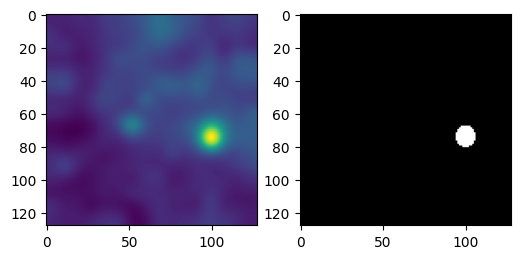

In [53]:
tiles = tile_predictions[(1, 0)]

visualize_tile(tiles[0], 0)

Our final result should be on a level of an image. That's why we will use joiner class to join all the data from tiles into an image level representation.

In [50]:
joiner = BasicPredictionJoiner(tile_predictions, tiler)

all_predictions = joiner.join_tile_predictions()

### Step 4: Visualization and evaluation

Once our data is joined, we can visualize full images as well as evaluate our ensemble.

First let's visualize our joined image.

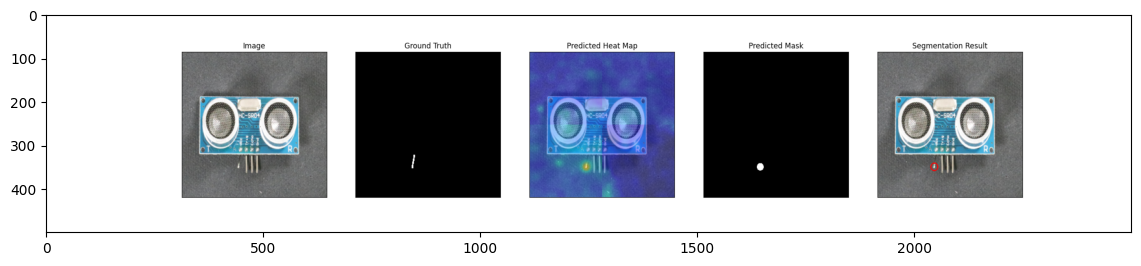

In [61]:
# create visualizer class
visualizer = Visualizer(mode=config.visualization.mode, task=config.dataset.task)

# visualize first batch
batch = all_predictions[0]
imgs = visualizer.visualize_batch(batch)

# get first image
image_0 = next(imgs)

# plot
plt.figure(figsize=(14,8))
plt.imshow(image_0)
plt.show()

And compute the metrics for joined images.

In [62]:
compute_metrics(all_predictions, config, image_threshold=0.5, pixel_threshold=0.5)

image_F1Score: 0.8032128810882568
image_AUROC: 0.8912999629974365
pixel_F1Score: 0.46348094940185547
pixel_AUROC: 0.9878893494606018
